# Инструкция по выполнению проекта:

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.



## Импорт основных библиотек и данных. Изучение данных и их подготовка к анализу

### Импорт библиотек и файлов с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
from scipy import stats as st
from datetime import datetime, timedelta

In [2]:
df_visits = pd.read_csv('visits_info_short.csv')
df_orders = pd.read_csv('orders_info_short.csv')
df_costs = pd.read_csv('costs_info_short.csv')

Делаем преднастройку - ограничиваем видимость для цифр с плавающей запятой в две цифры.

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Изучение данных

Посмотрим на имеющиеся в распоряжении данные. Для этого используем функцию inspect.

In [4]:
def inspect(df):
    display(df.sample(10, random_state=1)) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if 'datetime' in column_name:
            df[column_name] = pd.to_datetime(df[column_name])
        else:
            display(df[column_name].value_counts())
            print(50*'*')
    return df

In [5]:
for df in [df_visits, df_orders, df_costs]:
    inspect(df)

,User Id,Region,Device,Channel,Session Start,Session End
211274,738535139711,UK,Android,organic,2019-05-09 15:06:53,2019-05-09 15:48:50
273259,680497695721,Germany,Android,LeapBob,2019-09-02 14:07:28,2019-09-02 14:11:43
205897,728963351414,United States,Mac,organic,2019-10-29 10:45:58,2019-10-29 10:47:25
297860,174899252198,UK,PC,LeapBob,2019-10-11 01:38:37,2019-10-11 01:47:59
169513,513791433815,United States,Android,TipTop,2019-10-02 15:05:58,2019-10-02 15:29:16
68421,332224842734,United States,PC,organic,2019-07-07 21:03:48,2019-07-07 21:35:22
53262,112607694631,United States,Mac,FaceBoom,2019-06-25 00:17:22,2019-06-25 00:52:21
27056,797073249411,United States,Android,organic,2019-05-28 09:38:35,2019-05-28 09:38:49
226350,531038849208,UK,Android,OppleCreativeMedia,2019-06-08 14:39:12,2019-06-08 15:17:15
279171,856315246559,UK,PC,OppleCreativeMedia,2019-09-14 04:52:55,2019-09-14 04:56:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
Количество дубликатов - 0


,User Id
count,309901.00
mean,499766449382.69
std,288789916887.83
min,599326.00
25%,249369122776.00
50%,498990589687.00
75%,749521111616.00
max,999999563947.00


33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
214203066007     1
369265191867     1
346271445800     1
133742530598     1
279181973476     1
Name: user_id, Length: 150008, dtype: int64

**************************************************


United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

**************************************************


iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

**************************************************


organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

**************************************************


2019-06-27 14:56:41    3
2019-10-15 09:47:57    3
2019-08-25 08:20:51    3
2019-10-10 22:50:07    3
2019-10-22 17:17:39    3
                      ..
2019-08-10 14:18:14    1
2019-08-10 05:32:58    1
2019-08-10 02:14:48    1
2019-08-10 12:40:46    1
2019-10-31 14:17:43    1
Name: session_start, Length: 306813, dtype: int64

**************************************************


2019-07-16 02:23:30    3
2019-07-29 11:21:53    3
2019-08-03 06:31:26    3
2019-08-20 15:27:15    3
2019-09-23 20:37:13    3
                      ..
2019-08-10 14:15:39    1
2019-08-11 00:05:05    1
2019-08-10 23:01:52    1
2019-08-10 04:21:45    1
2019-10-31 15:17:04    1
Name: session_end, Length: 306793, dtype: int64

**************************************************


,User Id,Event Dt,Revenue
32012,419263491450,2019-07-30 23:59:07,4.99
38295,483568708610,2019-10-12 16:12:59,4.99
24544,448476047447,2019-10-16 06:11:23,4.99
29442,520659310653,2019-06-15 09:43:35,4.99
6270,680317225380,2019-07-05 13:01:50,4.99
11811,106927599817,2019-08-10 23:28:13,4.99
25721,854016361986,2019-10-21 21:52:12,4.99
12504,772315845552,2019-08-14 19:50:32,4.99
39984,662705152081,2019-10-29 13:53:48,4.99
13258,268123139092,2019-08-19 06:41:49,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
Количество дубликатов - 0


,User Id,Revenue
count,40212.00,40212.00
mean,499029531203.23,5.37
std,286093675967.16,3.45
min,599326.00,4.99
25%,251132440436.75,4.99
50%,498283972665.00,4.99
75%,743332711780.00,4.99
max,999895427370.00,49.99


901180916748    22
883098437811    20
75337957494     19
512471511263    19
295795879965    19
                ..
829252887757     1
499471996783     1
847348136580     1
390188868722     1
168548862926     1
Name: user_id, Length: 8881, dtype: int64

**************************************************


2019-10-26 06:49:22    2
2019-06-27 06:09:53    2
2019-09-14 23:35:11    2
2019-10-05 08:23:22    2
2019-10-11 20:55:22    2
                      ..
2019-08-20 02:51:09    1
2019-08-20 06:58:44    1
2019-08-20 14:41:23    1
2019-08-20 18:09:32    1
2019-10-31 13:29:06    1
Name: event_dt, Length: 40163, dtype: int64

**************************************************


4.99     38631
5.99       780
9.99       385
49.99      212
19.99      204
Name: revenue, dtype: int64

**************************************************


,dt,Channel,costs
1462,2019-05-23,WahooNetBanner,7.20
510,2019-09-28,RocketSuperAds,11.38
612,2019-07-12,TipTop,288.60
1322,2019-07-02,OppleCreativeMedia,14.75
993,2019-08-02,AdNonSense,26.25
190,2019-05-11,MediaTornado,11.52
1716,2019-08-05,lambdaMediaAds,4.00
1048,2019-09-26,AdNonSense,34.65
1407,2019-09-25,OppleCreativeMedia,16.50
881,2019-10-09,YRabbit,3.84


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
Количество дубликатов - 0


,costs
count,1800.00
mean,58.61
std,107.74
min,0.80
25%,6.50
50%,12.29
75%,33.60
max,630.00


2019-05-01    10
2019-08-22    10
2019-08-24    10
2019-08-25    10
2019-08-26    10
              ..
2019-07-01    10
2019-07-02    10
2019-07-03    10
2019-07-04    10
2019-10-27    10
Name: dt, Length: 180, dtype: int64

**************************************************


FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: channel, dtype: int64

**************************************************


6.40      26
3.36      21
9.60      20
16.80     19
11.55     17
          ..
203.30     1
184.30     1
186.20     1
172.90     1
2.40       1
Name: costs, Length: 608, dtype: int64

**************************************************


Данные имеют следующее содержание.
1) Таблица df_visits:
- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя

2) Таблица df_orders:
- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки
- Revenue — выручка

3) Таблица df_costs:
- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день  
      
  
В таблице отсутствуют пропуски.  
Для столбцов с датами указан неоптимальный формат. Скорректируем его.  
Также далее изменим наименование столбцов для дальнейшей работы с ними.

### Изменение типов данных столбцов
Так как у всех столбцов с датами сейчас установлен тип данных object, установим для столбцов с датами тип данных даты.

In [6]:
df_visits['session_start'] = pd.to_datetime(df_visits['session_start'])
df_visits['session_end'] = pd.to_datetime(df_visits['session_end'])
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt'])
df_costs['dt'] = pd.to_datetime(df_costs['dt']).dt.date 

### Удаление дубликатов
Проверим таблицы на наличие дубликатов.

In [7]:
print(df_visits.duplicated().sum())
print(df_orders.duplicated().sum())
print(df_costs.duplicated().sum())

0
0
0


При проверке массивов функцией inspect мы проверили отсуствие в таблице неявных дубликатов.  
Таким образом дубликатов не осталось. Данные готовы к анализу.

### Вывод
В рамках данного подготовительного шага были импортированы все требуемые библиотеки и таблицы, переименованы названные не по стандарту столбцы, изменен тип данных у столбцов с датами. Также данные были проверены на дубликаты и на пропуски (корректировки не потребовались).

## Создание функций для расчета и анализа LTV, ROI, удержания и конверсии

Для выполенния поставленной задачи будут использованы стандартные функции для расчета бизнес показателей. Этими функциями являются: 
1) Функция для создания пользовательских профилей get_profiles();   
2) Функция для расчёта удержания get_retention();  
3) Функция для расчёта конверсии get_conversion();   
4) Функция для расчёта LTV и ROI get_ltv().  

Дополнительно будут использованы следующие функции для построения графиков:
1) Функция для визуализации удержания plot_retention();  
2) Функция для визуализации конверсии plot_conversion();  
3) Функция для визуализации LTV и ROI plot_ltv_roi().

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [11]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных
### Создание пользовательских профилей
Создадим пользовательские профили с помощью функции get_profiles, а также определим минимальную и максимальную даты привлечения пользователей.

In [16]:
profiles = get_profiles(sessions=df_visits, orders=df_orders, events=None, ad_costs=df_costs)
display(profiles.head()) 
print('')
print('Минимальная дата привлечения пользователей', df_visits.groupby('user_id').
      agg({'session_start':'min'}).sort_values(by='session_start').min().dt.date)
print('')
print('Минимальная дата привлечения пользователей', df_visits.groupby('user_id').
      agg({'session_start':'min'}).sort_values(by='session_start').max().dt.date)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23



Минимальная дата привлечения пользователей session_start    2019-05-01
dtype: object

Минимальная дата привлечения пользователей session_start    2019-10-27
dtype: object


В файле представлены данные о привлечении уникальных пользователей с 01.05.2019 по 27.10.2019. 

### Определение стран пользователей
Далее определим, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Также сформируем таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [17]:
# Функция для требуемого анализа
def overall_division (column, description1, description2):
    # Подсчет всех уникальных пользователей
    data1 = profiles.groupby(column).agg({'user_id':'nunique'})
    data1.plot.pie(autopct='%.1f%%', figsize=(10, 10), subplots=True)
    plt.title('Круговая диаграмма распределения ' + description1)
    plt.ylabel('')
    plt.show()
    # Подсчет всех платящих уникальных пользователей
    data2 = profiles.query('payer == True').groupby(column).agg({'user_id':'nunique'})
    data2.plot.pie(autopct='%.1f%%', figsize=(10, 10), subplots=True)
    plt.title('Круговая диаграмма распределения ' + description2)
    plt.ylabel('')
    plt.show()
    # Объединение таблиц
    data = data1.merge(data2[['user_id']], 
                                       how='inner', on=column).rename(columns={'user_id_x': 'unique_users', 
                                                                                 'user_id_y': 'unique_payers'})

    data['payer_percent'] = data['unique_payers']/data['unique_users']*100
    return data


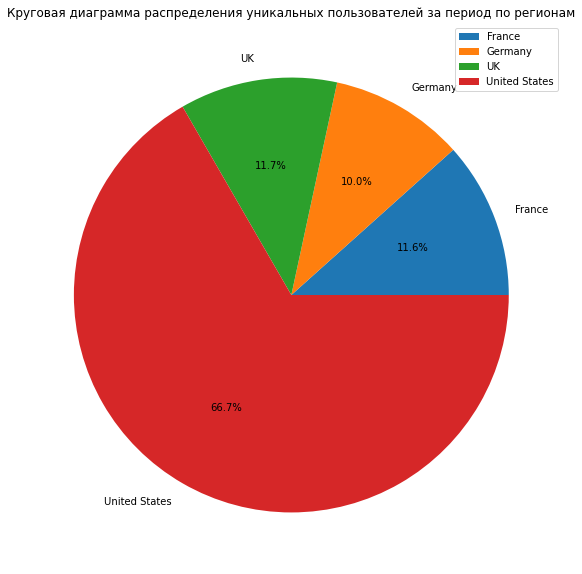

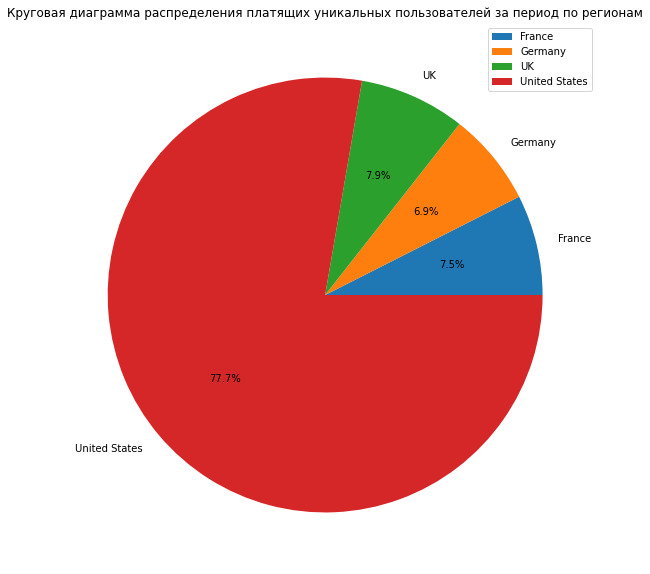

,unique_users,unique_payers,payer_percent
region,,,
France,17450,663,3.80
Germany,14981,616,4.11
UK,17575,700,3.98
United States,100002,6902,6.90


In [18]:
overall_division('region', 'уникальных пользователей за период по регионам', 
                 'платящих уникальных пользователей за период по регионам')

В приложение приходят пользователи из США, Германии, Франции и Великобритании.  
Наибольшее количество пользователей приходится на США. Это справедливо и для общего количества пользователей, и для платящих пользователей.

### Анализ используемых пользователями устройств
Аналогично определим разбивку по устройствам пользователей. 

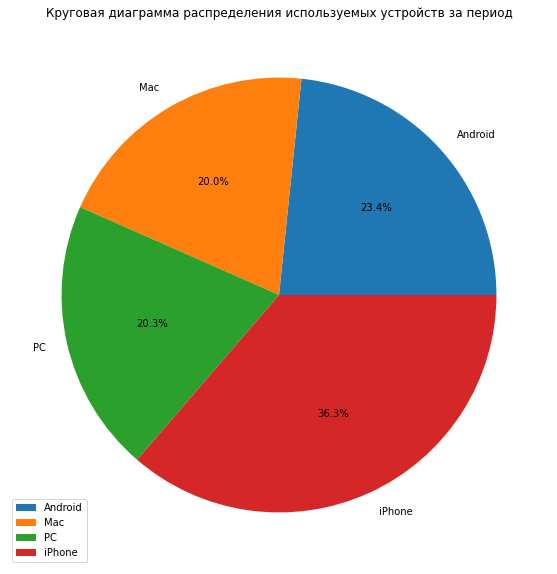

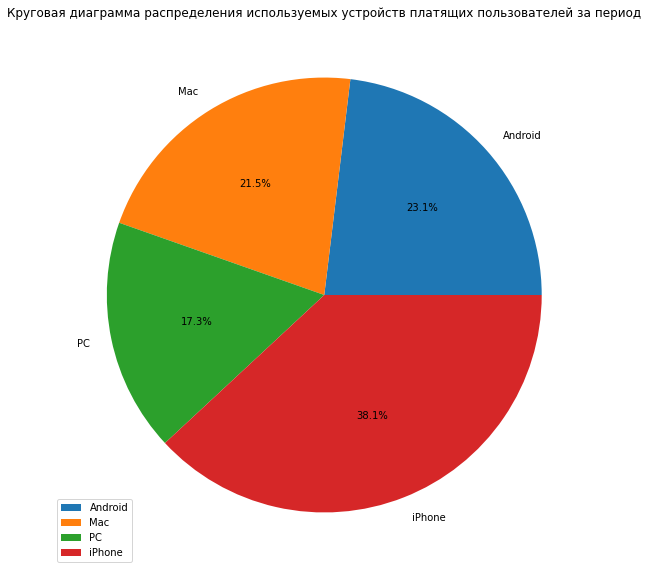

,unique_users,unique_payers,payer_percent
device,,,
Android,35032,2050,5.85
Mac,30042,1912,6.36
PC,30455,1537,5.05
iPhone,54479,3382,6.21


In [19]:
overall_division('device', 'используемых устройств за период', 
                 'используемых устройств платящих пользователей за период')

Более трети используемых устройств - устройства iPhone. Остальные доли используемых устройств распределены почти равномерно между устройствами на Android, Mac и PC.  

### Изучение рекламных источников
Определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу с долей платящих пользователей для каждого канала привлечения. 

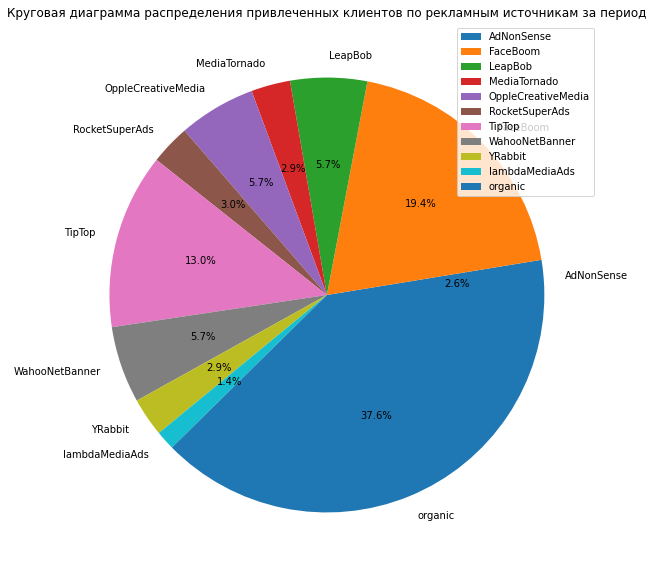

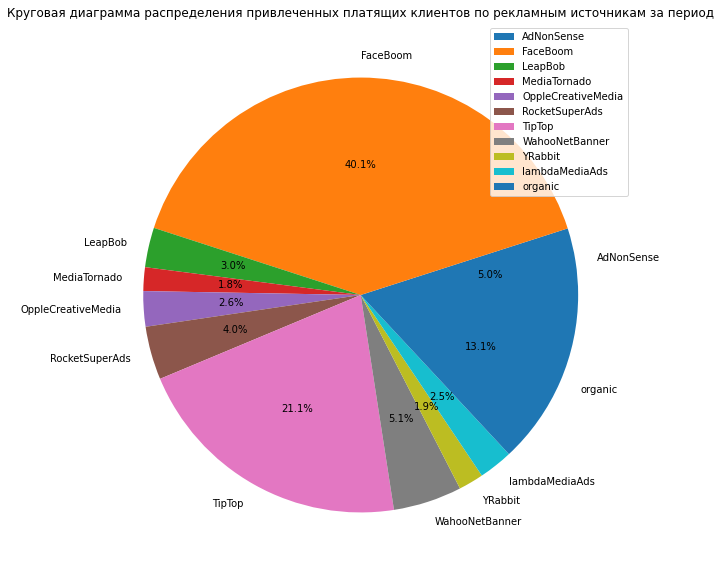

,unique_users,unique_payers,payer_percent
channel,,,
AdNonSense,3880,440,11.34
FaceBoom,29144,3557,12.20
LeapBob,8553,262,3.06
MediaTornado,4364,156,3.57
OppleCreativeMedia,8605,233,2.71
RocketSuperAds,4448,352,7.91
TipTop,19561,1878,9.60
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83


In [20]:
overall_division('channel', 'привлеченных клиентов по рекламным источникам за период', 
                 'привлеченных платящих клиентов по рекламным источникам за период')

Общее количество привлеченных клиентов и количество привлеченных платящих клиентов сильно отличаются для разных рекламных источников. Больше всего уникальных клиентов было привлечено посредством organic переходов. Однако доля платящих пользователей для этого источника рекламы только на третьем месте.  
Наибольшее количество платящих клиентов составляют клиенты, пришедшие из FaceBoom (40% от общего количества платящих клиентов).

### Вывод
В файле представлены данные о привлечении уникальных пользователей в период с 01.05.2019 по 27.10.2019.  

Наибольшее количество пользователей - это пользователи из США. Они составляют 2/3 от общего количества уникальных пользователей (100002 пользователя из 150008) и чуть более 3/4 от уникальных платящих пользователей (6902 пользователя). Пользователи остальных регионов распределены примерно равномерно.  

Более трети используемых устройств - устройства iPhone. Остальные доли используемых устройств распределены почти равномерно между устройствами на Android, Mac и PC. При этом наибольшая доля платящих пользователей у тех, кто устройства Mac (эта доля составляет 6,36% от общего количества уникальных пользователей, использующих это устройство), что эквивалентно 1912 уникальным пользователям за рассмотренный период. Платящие пользователи iPhone составляют 6,21% от общего количества пользователей, использующих это устройство (3382 пользователя). Наименьшее количество и доля платящих пользователей - пользователи, использующие PC - 1537 и 5,05%, соответственно.   

Наибольшее количество пользователей было привлечено через organic переходы - 37,6%, или 56439 уникальных пользователей. На втором месте источник FaceBoom (19.4% / 29144 польз.), на третьем - TipTop (13,0% / 19561 польз.). Остальные источники привлекли до 6% от общего количества уникальных пользователей.  
Распределение платящих пользователей значительно отличается. Чуть более 40% платящих уникальных пользователей были привлечены через FaceBoom (3557 польз.), Около 21% платящих пользователей привлечены через TipTop (1878). На третьем месте по количеству уникальных платящих пользователей - те, кто перешли в приложение посредством organic переходов - 13,1% / 1160 пользователей. Остальные платящие пользователи распределны между прочими рекламными источниками, и для каждого доля от общего кол-ва уникальных платящих пользователей составляет до 5,1%.  
Доли уникальных платящих пользователей из общего кол-ва привлеченных через источник пользователей распределены следующим образом: FaceBoom 12,2%, AdNonSense 11,34%, lambdaMediaAds 10,47%. По остальным рекламным источникам доли платящих составляют до 10%.  
Учитывая доли платящих пользователей, на текущий момент можно предположить, что целесообразно увеличить расходы на рекламу в FaceBoom, AdNonSense и lambdaMediaAds. Проверим это дальнейшими метриками.

## Маркетинг
### Расчет расходов на маркетинг
Проверим, сколько всего денег было потрачено на маркетинг. Также оценим расходы на маркетинг по источникам и по времени.

In [21]:
print('Общие расходы на рекламу за период с 01.05.2019 по 27.10.2019 составляют', int(df_costs['costs'].sum()), '$')

Общие расходы на рекламу за период с 01.05.2019 по 27.10.2019 составляют 105497 $


In [22]:
df_costs_grouped = df_costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
df_costs_grouped

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


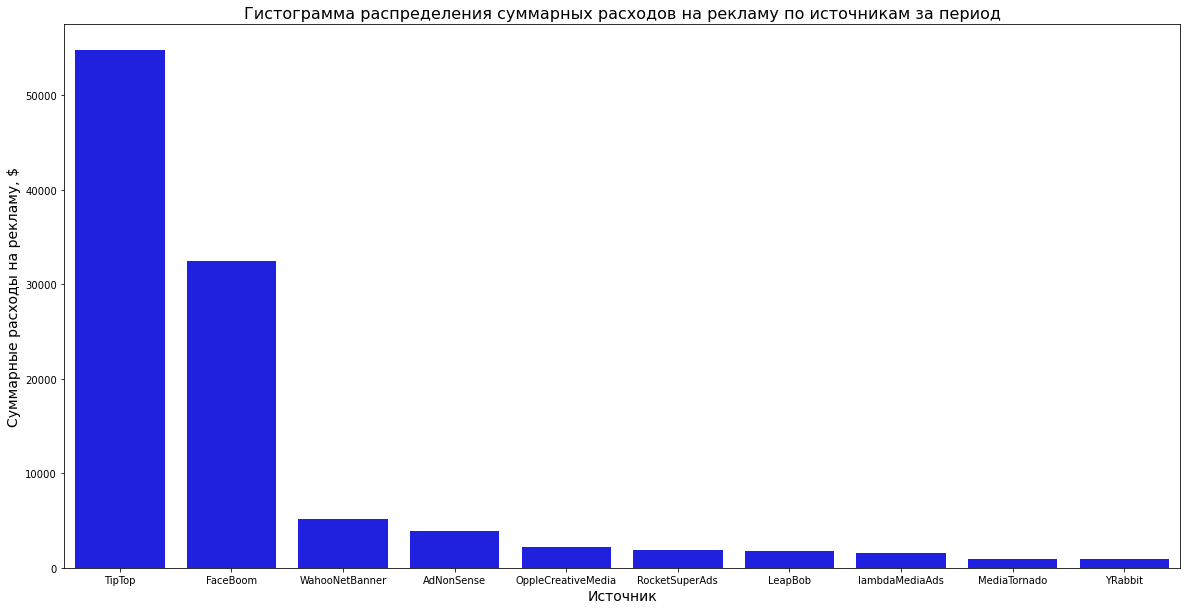

In [23]:
plt.figure(figsize=(20, 10))
sns.barplot(x='channel', y='costs',data=df_costs_grouped.reset_index(), color='blue')
plt.title('Гистограмма распределения суммарных расходов на рекламу по источникам за период', fontsize=16)
plt.xlabel('Источник', fontsize=14)
plt.ylabel('Суммарные расходы на рекламу, $', fontsize=14)
plt.show()

Подавляющее большинство расходов приходится на два источника - FaceBoom и TipTop.  
Проверим изменение расходов на рекламу по источникам в динамике. Сначала оценим, как меналась общая сумма расходов в разрезе периода. Для этого добавим в таблицу df_costs месяц, в который были понесены расходы. 

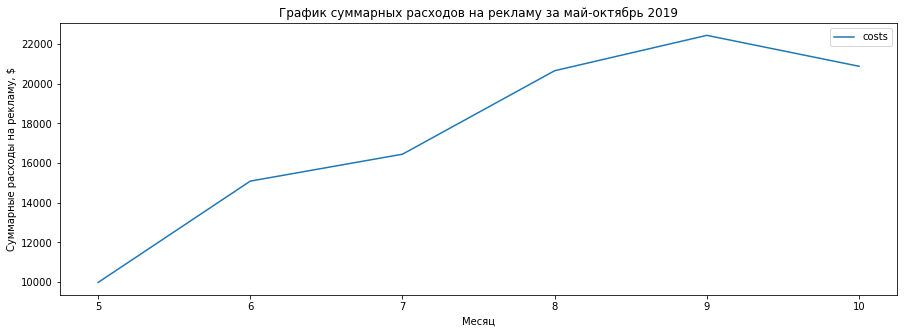

In [24]:
# Добавляем столбец с месяцем, в который понесены расходы
df_costs['month'] = pd.DatetimeIndex(df_costs['dt']).month

# Группируем таблицу и составляем график
df_costs_by_month = df_costs.groupby(
    'month').agg({'costs':'sum'}).sort_values(by='costs', ascending=False).sort_values(by='month')

df_costs_by_month.plot(style = '-', figsize=(15, 5))
plt.title('График суммарных расходов на рекламу за май-октябрь 2019')
plt.xlabel('Месяц')
plt.ylabel('Суммарные расходы на рекламу, $')
plt.show()

Наблюдаем стабильный рост со спадом расходов в октябре до сентябрьского уровня - это можно связать с тем, что, возможно, у нас имеются данные за неполный октябрь.  
Теперь проверим динамику по источникам. 

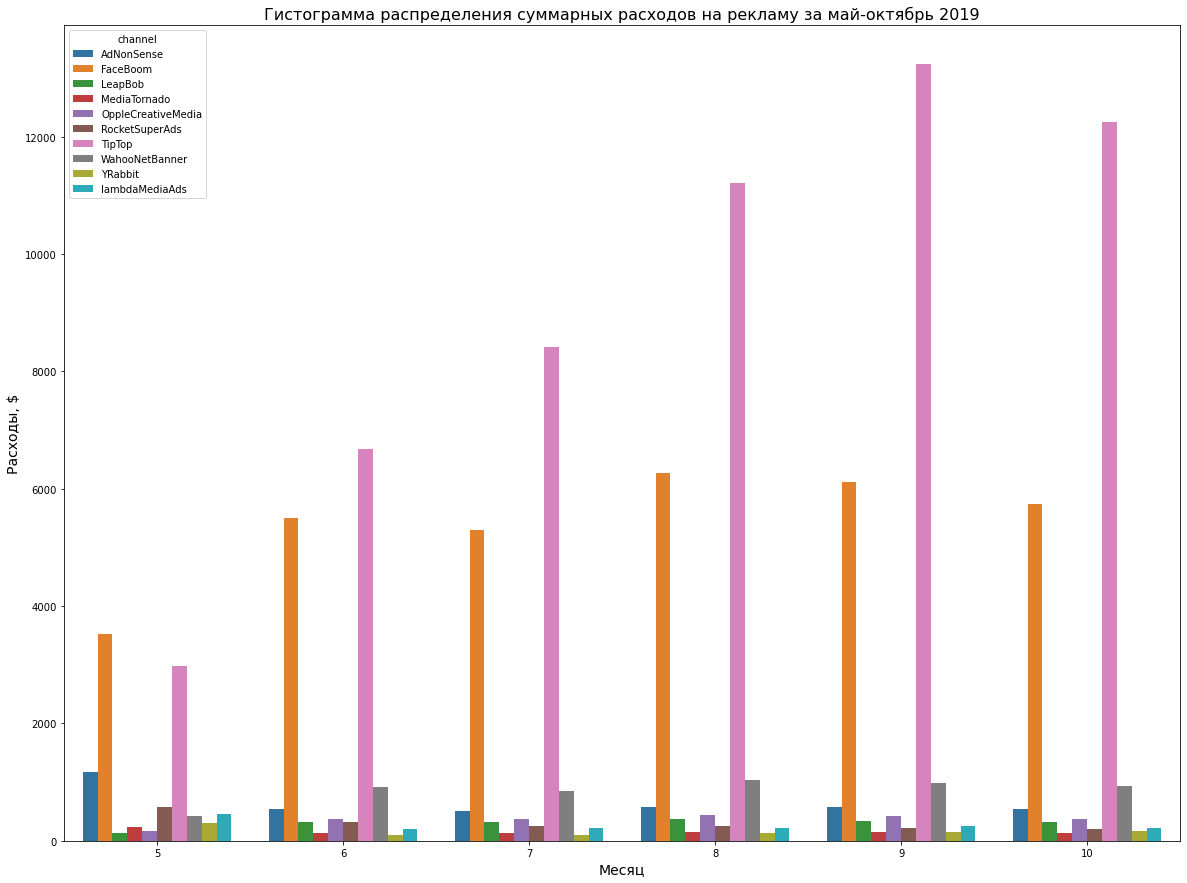

In [25]:
# Группируем таблицу и составляем график
df_costs_by_channel_month = df_costs.groupby([
    'channel', 'month']).agg({'costs':'sum'}).sort_values(by='costs', ascending=False).sort_values(by=['channel', 'month'])
plt.figure(figsize=(20, 15))
sns.barplot(x='month', y='costs',data=df_costs_by_channel_month.reset_index(), hue='channel')
plt.title('Гистограмма распределения суммарных расходов на рекламу за май-октябрь 2019', fontsize=16)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Расходы, $', fontsize=14)
plt.show()

Видим, что TipTop повторяет динамику общих расходов на рекламу (можно связать с тем, что расходы на этот источник составляют чуть больше половины общих расходов). По FaceBoom динамика отличается. На графике виден рост расходов в июне, после которого расходы на рекламу в этом источнике находились примерно на одном уровне.   
Построим гистограмму распределения без фаворитов FaceBoom и TipTop для дополнительной наглядности.

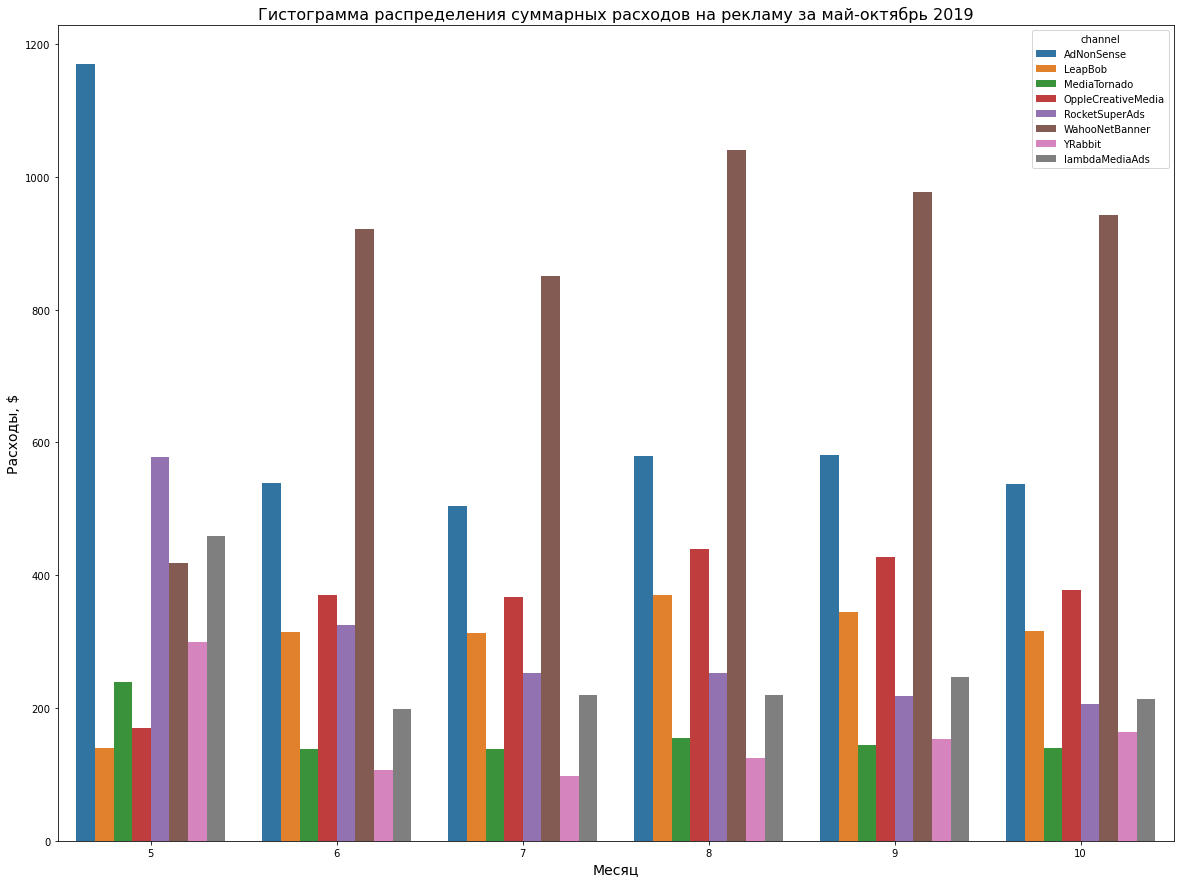

In [26]:
plt.figure(figsize=(20, 15))
sns.barplot(x='month', y='costs',
            data=df_costs_by_channel_month.query('channel != "FaceBoom" and channel != "TipTop"').reset_index(), hue='channel')
plt.title('Гистограмма распределения суммарных расходов на рекламу за май-октябрь 2019', fontsize=16)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Расходы, $', fontsize=14)
plt.show()

Эти источники вносят не существенный вклад в общие расходы на рекламу, однако тут наблюдается четкая динамика - по части источников идет спад расходов, по части - наоборот. 

### Стоимость привлечения пользователя по источникам
Проверим, сколько в среднем стоило привлечение одного покупателя из каждого источника. Для этого рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика с использованием профилей пользователей.  

Стоимость привлечения каждого посетителя отражена в столбце acquisition_cost таблицы profiles. Для того, чтобы найти среднюю стоимость привлечения одного пользователя для всего проекта, достаточно суммарную стоимость привлечения пользователей разделить на количество платящих пользователей.  

In [27]:
print('Средняя стоимость привлечения одного пользователя для всего проекта', 
      round(profiles['acquisition_cost'].sum()/profiles['user_id'].count(), 2), 
      '$ (с учетом клиентов, пришедших посредством organic переходов).')
print('Средняя стоимость привлечения одного пользователя для всего проекта', 
      round(profiles['acquisition_cost'].sum()/profiles.query('acquisition_cost != 0')['user_id'].count(), 2), 
      '$ (с учетом только привлеченных за деньги клиентов).')

Средняя стоимость привлечения одного пользователя для всего проекта 0.7 $ (с учетом клиентов, пришедших посредством organic переходов).
Средняя стоимость привлечения одного пользователя для всего проекта 1.13 $ (с учетом только привлеченных за деньги клиентов).


Проверим стоимость привлечения пользователей для каждого источника трафика, и составим гистограмму.

In [28]:
profiles.pivot_table(index='channel', 
                     values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', 
                                                                            ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


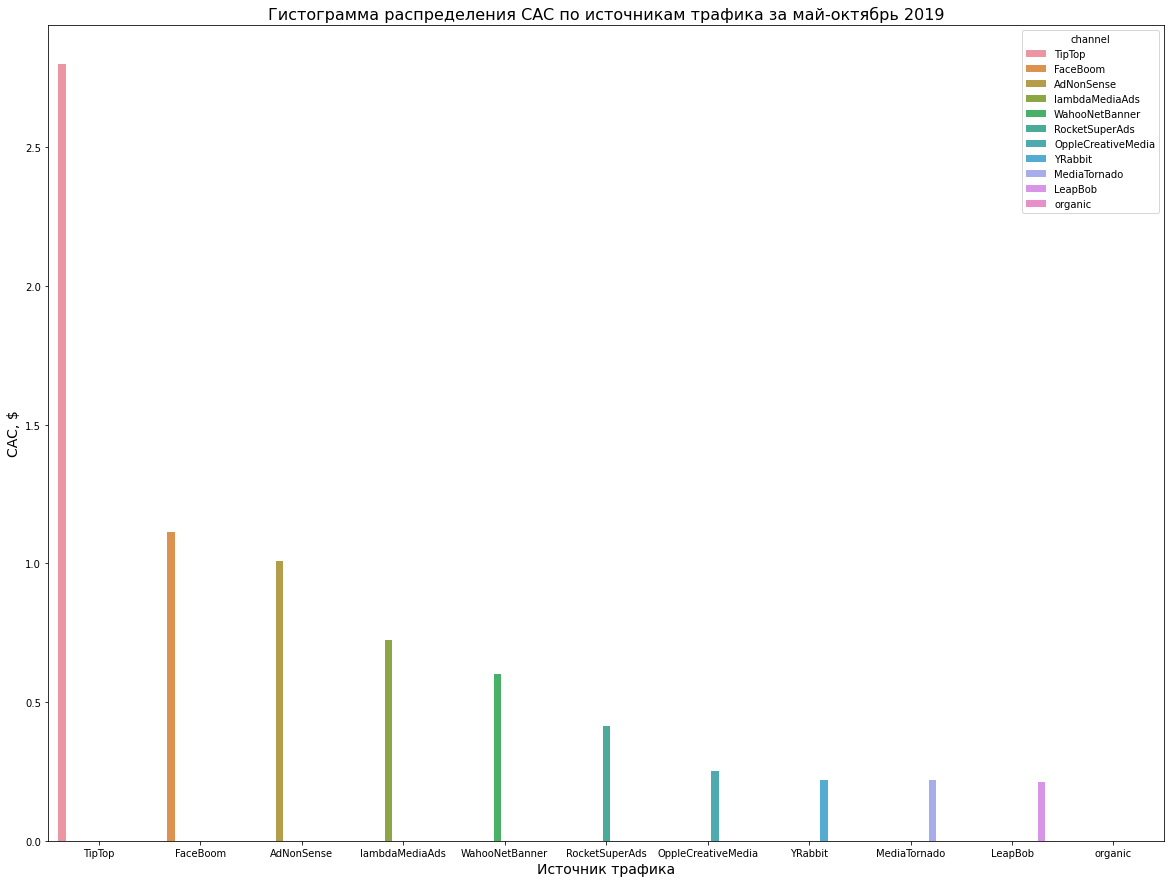

In [29]:
plt.figure(figsize=(20, 15))
sns.barplot(x='channel', y='acquisition_cost',
            data=profiles.pivot_table(index='channel', 
                     values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', 
                                                                            ascending=False).reset_index(), hue='channel')
plt.title('Гистограмма распределения CAC по источникам трафика за май-октябрь 2019', fontsize=16)
plt.xlabel('Источник трафика', fontsize=14)
plt.ylabel('CAC, $', fontsize=14)
plt.show()

САС для источника трафика TipTop составляеи 2,8$, что более чем в два раза больше, чем по остальным источникам трафика.

### Вывод
Суммарные расходы на рекламу за период с 01.05.2019 по 27.10.2019 составляют 105497 $. Из них чуть больше половины расходов приходится на рекламу в TipTop (54751,3 доллара в абсолютной величие, или 51,9 %). Далее следуют расходы на рекламу в FaceBoom - 32445,6 долларов, или 30,7%. 
Расходы на рекламу в остальных источниках в разы меньше, и составляют до 5% на источник от общей суммы расходов на рекламу.  
На графике динамики расходов на рекламу виден стабильный рост расходов с мая 2019 по сентябрь 2019. Суммарные расходы на рекламу в октябре были примерно на уровне августовских, что может быть связано с неполными данными за последний месяц (учитывая, что в данных крайний уникальный клиент был привлечен 27.10.2019).  

Расходы на рекламу TipTop имеют ту же динамику, что и общие расходы на рекламу (стабильный рост со спадом в октябре).  
В FaceBoom инвестиции производились в меньшем объеме, при этом сами расходы производились примерно равномерно с июня по октябрь.  
Среди более мелких рекламных источников наблюдается резкое уменьшение инвестиций в рекламу до 2 раз у AdNonSense, MediaTornado, RocketSuperAds, lambdaMediaAds.  

Средняя стоимость привлечения одного пользователя для всего проекта 1.13$. В этом значении не учтены клиенты, пришедшие через organic переходы.  

Наибольшая CAC у TipTop - 2,8$. Это означает, что на привлечение одного платящего пользователя в среднем уходит почти 3 доллара.  
Стоимость привлечения одного платящего пользователя в FaceBoom составляет 1,11 долларов, в AdNonSense - 1,01 доллар. CAC остальных рекламных источников менее 1 доллара.

## Оценка окупаемости рекламы для привлечения пользователей
В рамках оценки окупаемости рекламы необходимо определить момент и горизонт анализа. Моментом анализа является дата 1 ноября 2019 года, а горизонтом анализа - 14 дней, так как в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.  
Также исключим из наших данных весь органический трафик, так как по нему мы не вкладываем инвестиций, но он приносит определенную долю дохода. 

In [30]:
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14 
profiles = profiles.query('channel != "organic"').reset_index(drop = True)
df_visits = df_visits.query('channel != "organic"').reset_index(drop = True)
df_costs = df_costs.query('channel != "organic"').reset_index(drop = True)

### Анализ общей окупаемоси рекламы
Для расчета и визуализации LTV и ROI используем функции get_ltv() и plot_ltv_roi().  
Также построим графики динамики LTV, CAC и ROI.  

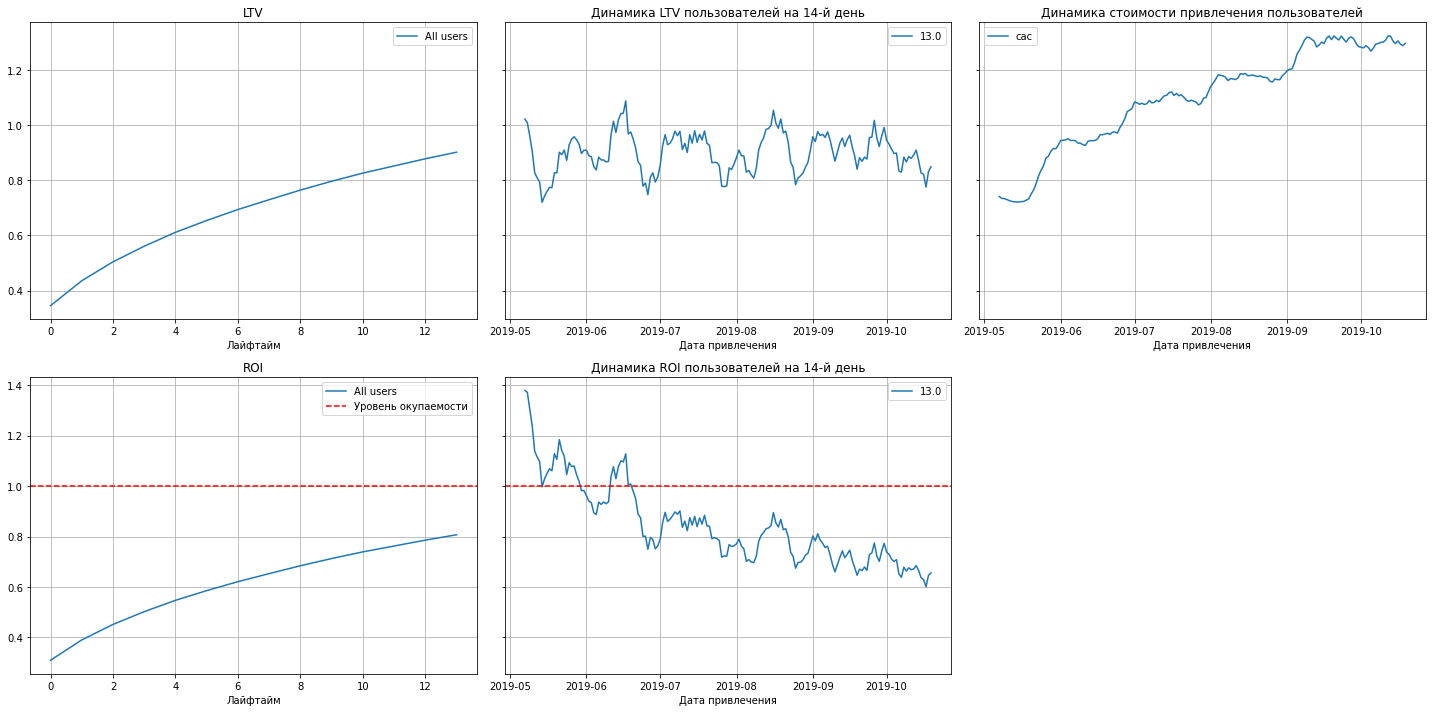

In [31]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Показатель LTV стабилен, то есть пожизненная ценность клиента не ухудшается.   
Стоимость привлечения одного клиента имеет стабильную тенденцию роста до октября. Сильный скачок стоимости привлечения произошел в мае. После этого показатель ежемесячно увеличивался, вплоть до октября.     
Реклама не окупается. К 14-ому дню ROI по приложению не выходит на уровень окупаемости.  
Однако при этом мы видим, что падение ROI произошло в мае (в месяце, когда произошел резкий скачок стоимости привлечения пользователей). После майского падение показатель стабильно ухудшался. 

### Анализ окупаемости рекламы с разбивкой по рекламным каналам
Далее произведем анализ окупаемости рекламы с разбивкой по рекламным каналам. 

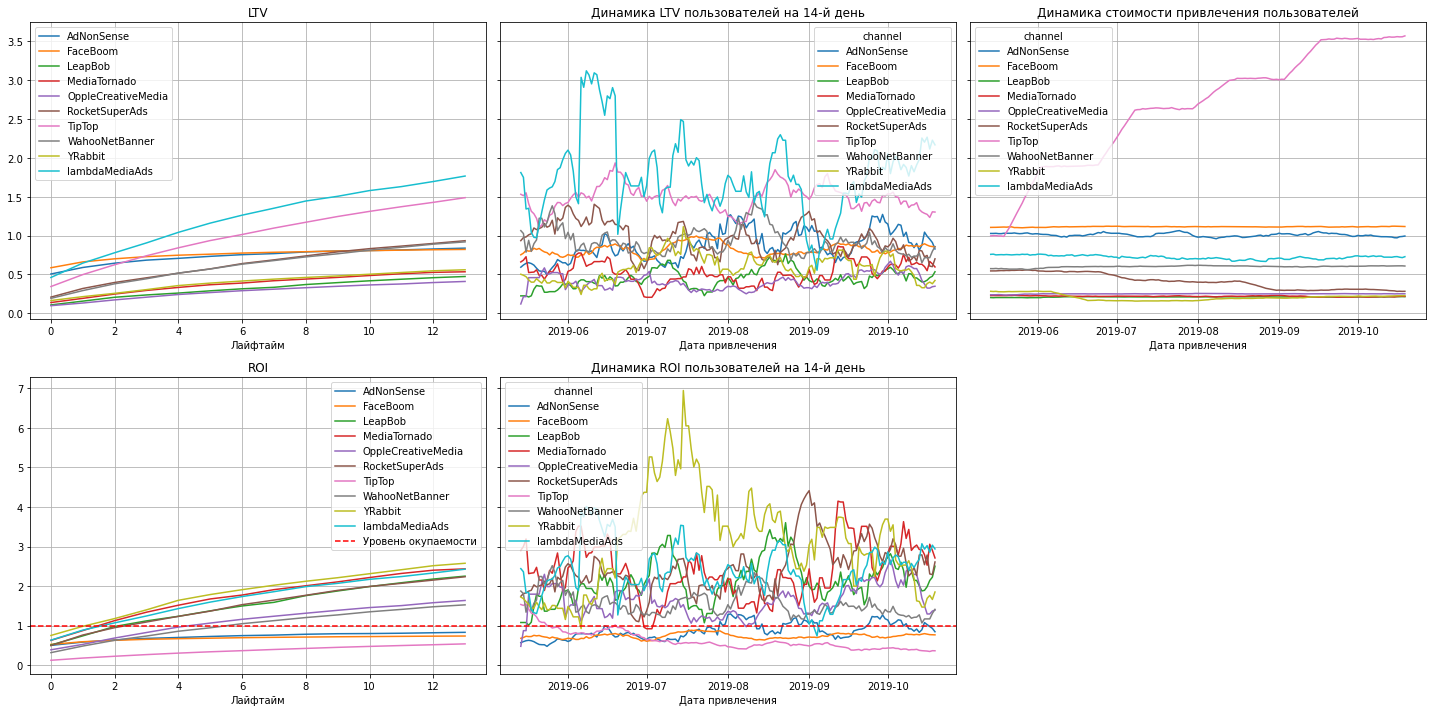

In [32]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Наилучшая пожизненная ценность клиентов у каналов lambdaMediaAds и TipTop. Однако при этом клиенты TipTop имеют наихудшую окупаемость, о чем говорит график ROI.  
За черту окупаемости к 14 дню не выходят только TipTop,FaceBoom и AdNonSense.  

Динамика пожизненной ценности клиентов примеро сопоставима для всех каналов рекламы.  
Сильнее остальных выделяется динамика пожизненной ценности для пользователей из канала lambdaMediaAds. Пик по этому каналу приходился на июнь 2019, самая крупная просадка LTV для этого канала приходится на начала сентября, после чего по каналу идет стабильный прирост пожизненный ценности пользователей с незначительными просадками.  

Динамика стоимости привлечения пользователей для всех каналов стабильна, и находится на примерно одном уровне на протяжении всего периода наблюдений. Единственным исключением является TipTop, по которому идет постоянное увеличение стоимости привлечения пользователей.  

Динамика окупаемости инвестиций говорит нам о том, что инвестиции в рекламу через FaceBoom и TipTop стабильно не окупаются. Причем для канала рекламы TipTop пересечение грани окупаемости приходится на май, когда в данный канал начали вливаться существенные инвестиции.   
Канал рекламы AdNonSense находится на грани окупаемости.  
С остальными каналами ситуация обстоит лучше. Они выше границы окупаемости, с периодическими просадками.  
Интересный результат показываел канал YRabbit, по которому в июле был сильный рост показателя. 


### Анализ окупаемости рекламы с разбивкой по странам  

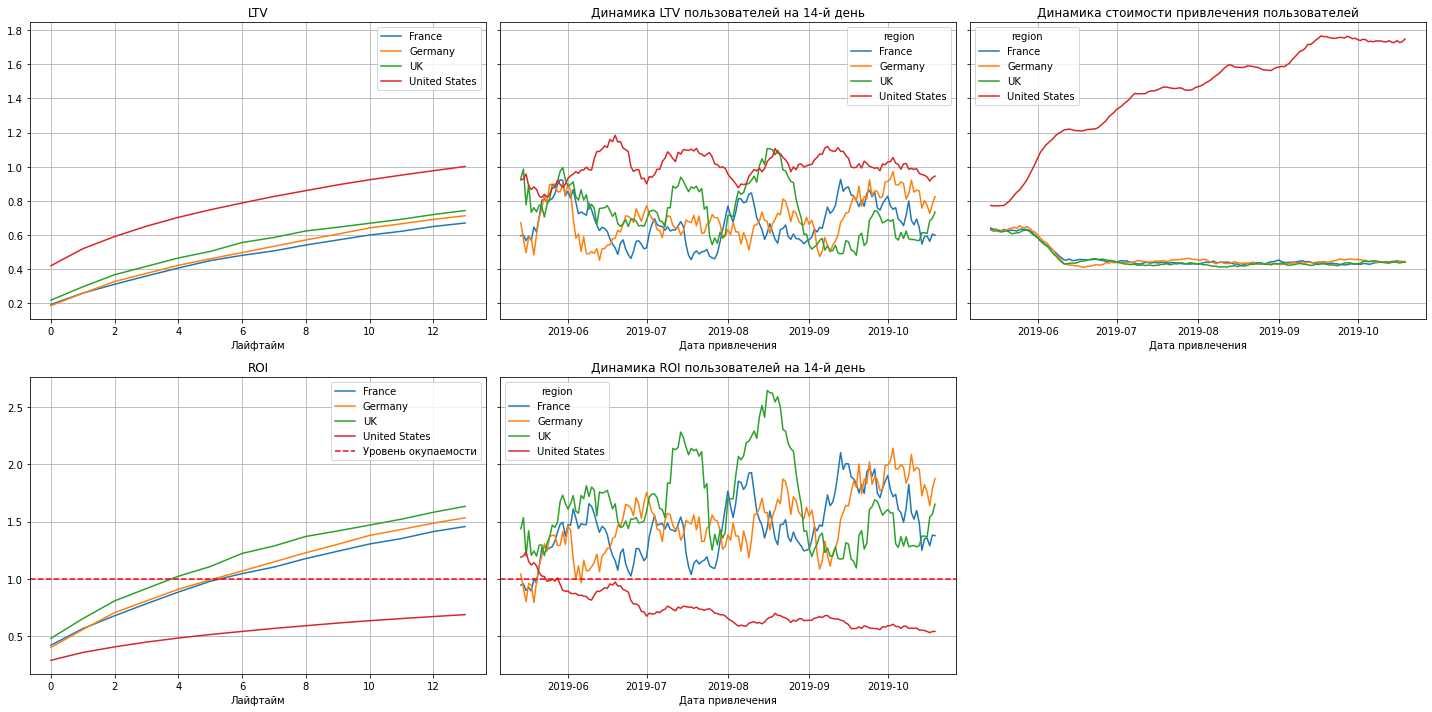

In [33]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Наибольшей пожизненной ценностью клиента являются пользователи из США. Но при этом инвестиций для пользователей из США к 14 дню не окупаются. По остальным странам же инвестиции окупаются к 4-ому дню жизненного цикла.  
По динамике ROI и CAC видно, что ситуация с пользователями из США начала ухудшаться в мае, и тенденция ухудшается с каждым месяцем.  
Для остальных стран наблюдалось снижение стоимости привлечения пользователей в июне, после чего динамика показателей была стабильна.  

### Анализ окупаемости рекламы с разбивкой по устройствам

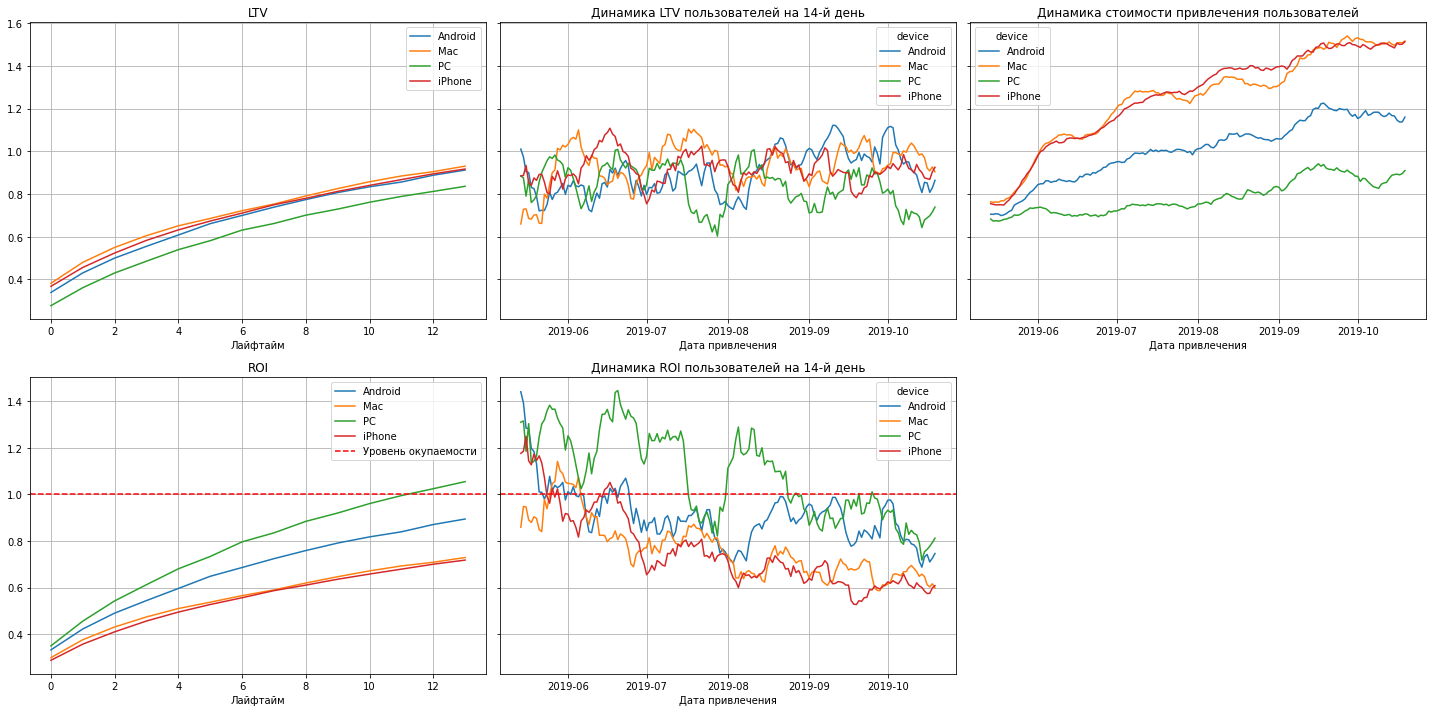

In [34]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По данным графикам можно сделать вывод, что наибольшая стоимость привлечения пользователей приходится на устройства Apple.  
При этом ни iPhone, ни Mac не выходят в окупаемость по итогу 14 дней горизонта анализа.  
В плане ROI окупаются только пользователи персональных компьютеров.  
Динамика ROI повторяет общую динамику окупаемости инвестиций на рекламу, и к октябрю даже пользователи ПК перестают быть окупемыми.   

### Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам
Для проверки конверсии и удержания воспользуемся функциями get_conversion(), plot_conversion(), get_retention() и plot_retention().
#### Графики конверсии и удержания по устройствам

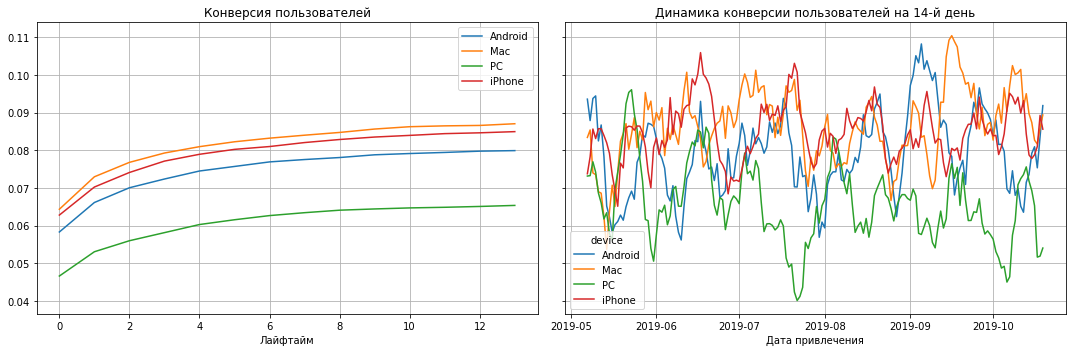

In [35]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей Apple производится регулярно и лучше, чем у пользователей PC и Android.  
При этом можно проследить рост конверсии с мая (когда начались большие инвестиции в рекламу).

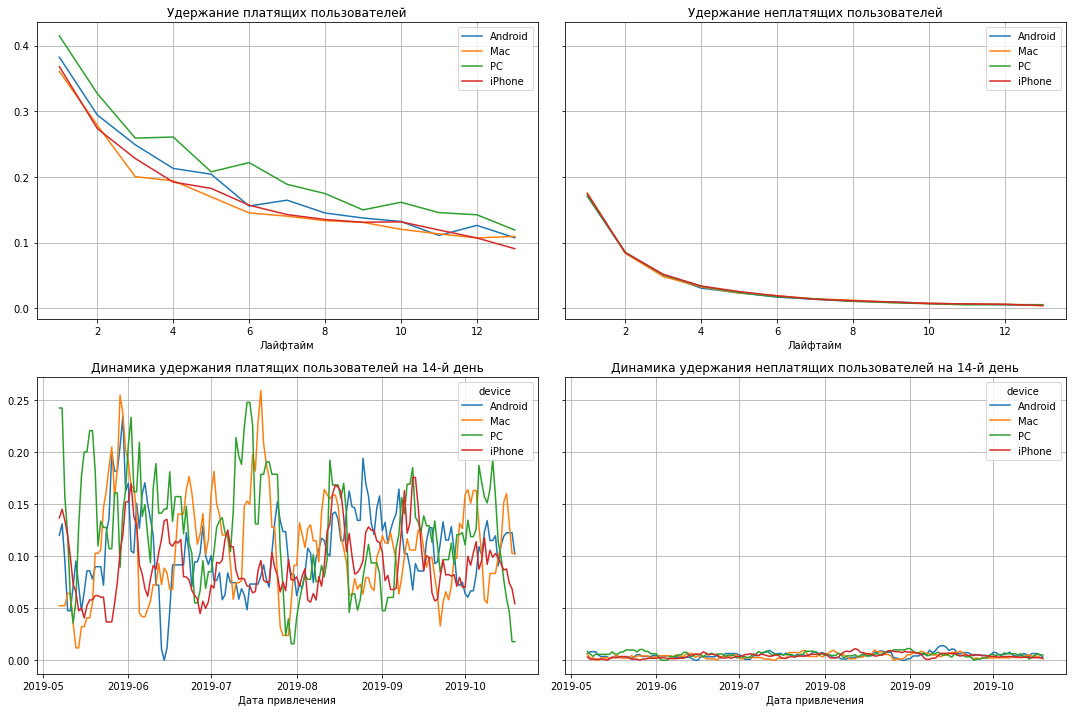

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей примерно на одном уровне, при этом у пользователей Apple оно чуть хуже. Критичных проблем не наблюдается. 

#### Графики конверсии и удержания по странам

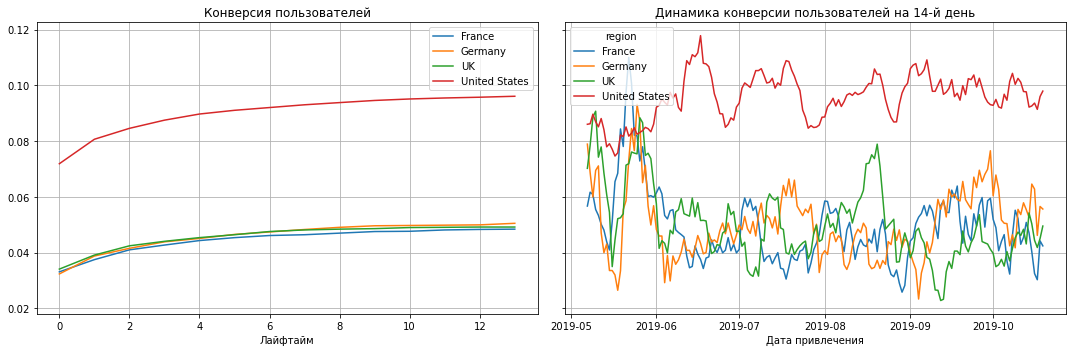

In [37]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучшая конверсия у пользователей из США - она примерно в два раза превышает конверсию пользователей других стран.

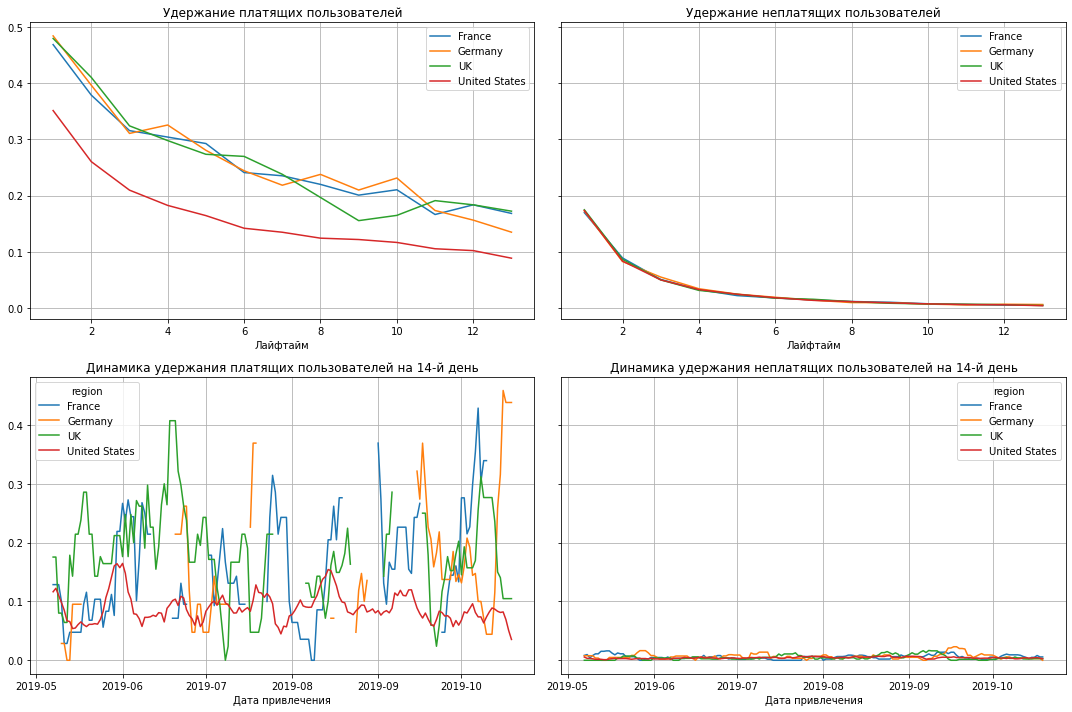

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей из США ниже, чем во всех остальных регионах. Это повод проверить, что не так у пользователей из США.  

#### Графики конверсии и удержания по рекламным каналам

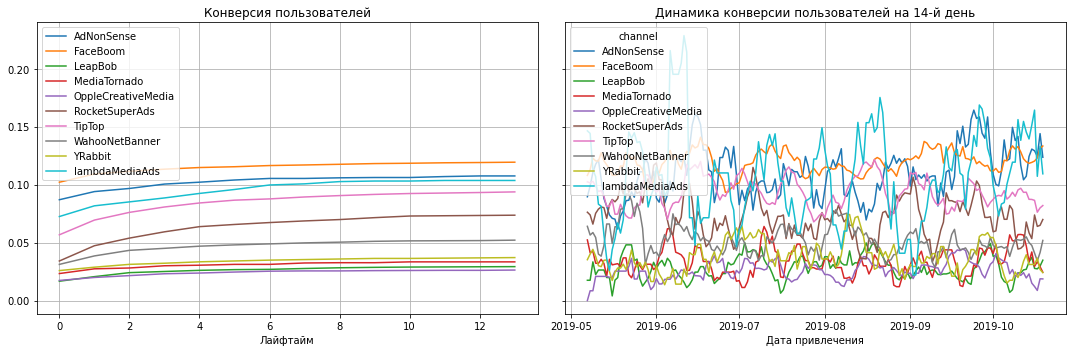

In [39]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, df_orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

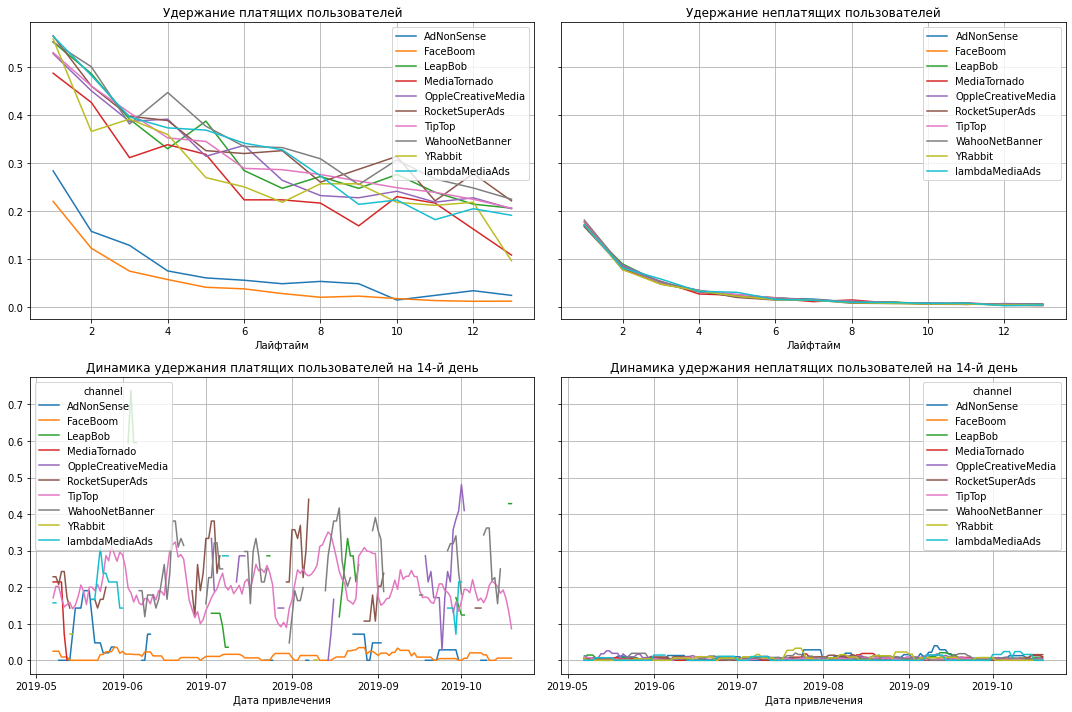

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Наблюдается аномально низкий коэфициент удержания для пользователей, пришедших по каналу Faceboom. Также повод для проверки.

## Общие выводы
В целом, на 14 день с момента привлечения клиента реклама не окупается. Обращаю внимание, что динамика уменьшения ROI началась с марта 2019, когда начались масштабные инвестиции в рекламный канал TipTop.
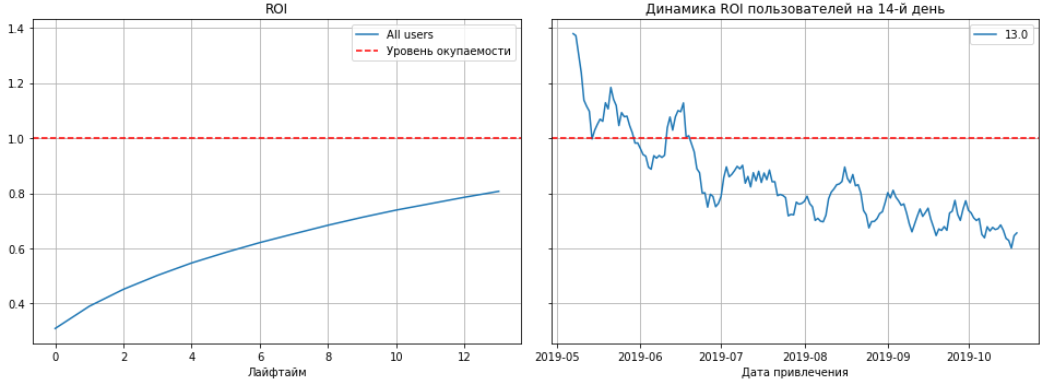

О причинах проблем окупаемости и о возможных вариантах решения этих проблем ниже.   
1) Значительное увеличение инвестиций в рекламный канал TipTop при его наихудшей окупаемости среди всех каналов рекламы. 
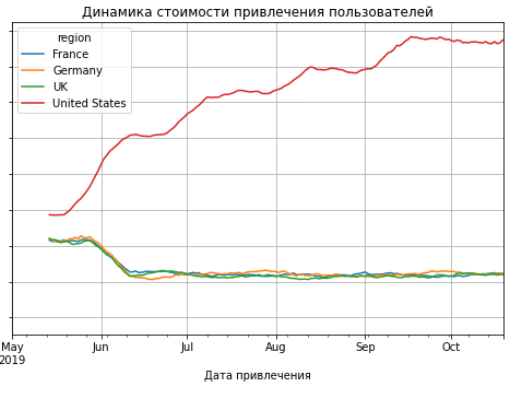 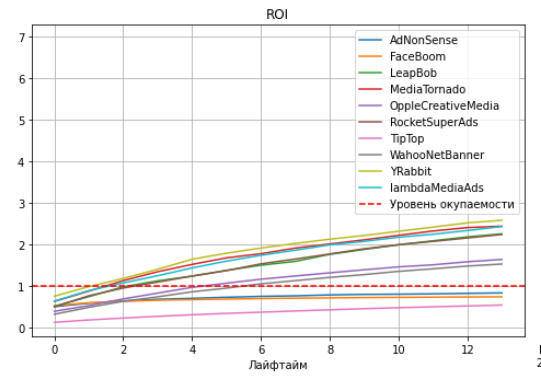
Конверсия и удержание пользователей канала TipTop стабильны, роста пользователей в соответствии с вкладываемыми инвестициями не происходит.  
Возможно, реклама приложения показывается не целевым пользователям, так как количество платящих пользователей, пришедших из этого канала с мая 2019 года существенно не изменилось. 

2) Инвестиции, вложенные в рекламу пользователям из США стабильно не окупаются, что также началось в мае 2019. 
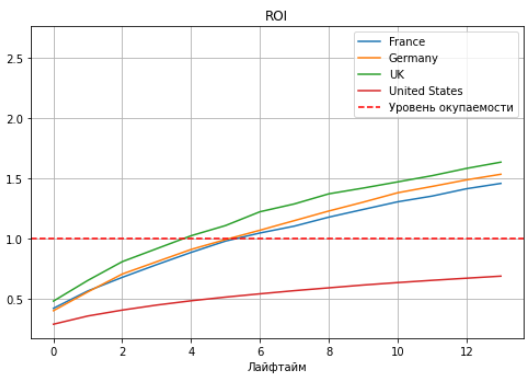
Низкое ROI для пользователей из США может быть связано с плохим удержанием платящих пользователей при наибольшем показателе конверсии пользователей среди всех регионов (а также наибольшем количестве пользователей из этого региона). Рекомендуется проверить систеему стимулирования пользователей из США к повторным покупкам. 
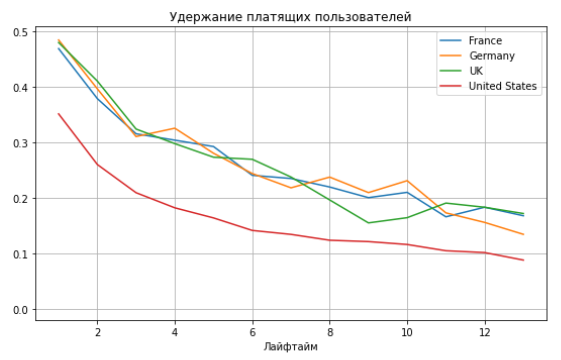

3) Аналогично снижают общую окупаемость пользователи устройств Apple (с учетом того, что больше всего платящих пользователей используют устройства iPhone), а также Android.
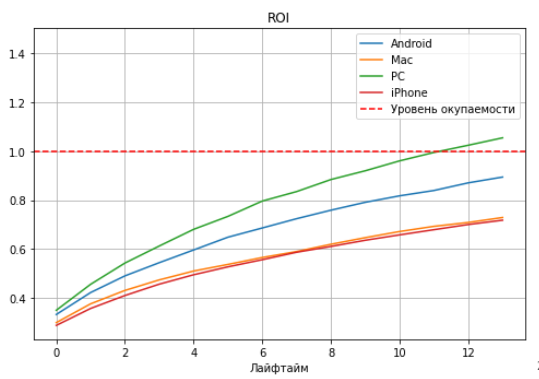
С конверсией и удержанием пользователей этих устройств критичных проблем не выявлено. Удержание пользователей Apple чуть хуже, чем пользователей остальных устройств, но разница не критична.  
Рекомендуется, также, проверить таргетированность рекламы. 
Помимо этого наблюдается плохая конверсия пользователей PC, на что предлагается обратить внимание.

4) Проблемы с удержанием клиентов из канала рекламы Faceboom. При достойных показателях конверсии, коэффициент удержания пользователей этого канала аномально низкий.  
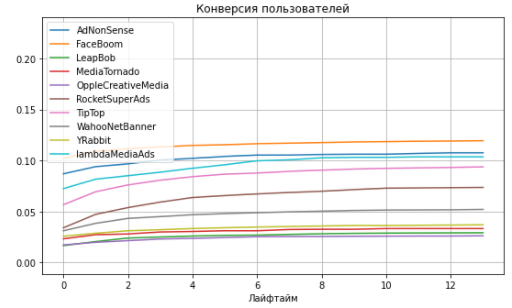 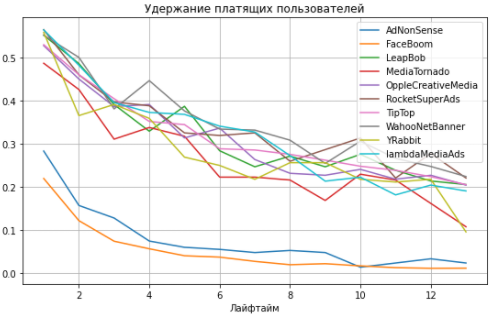
Расходы на рекламу приложения для пользователей Faceboom на втором месте. Эти расходы оправдываются лидирующими показателями конверсии, однако, видимо, также как и для пользователей из США, необходимо проверить системы повторного стимулирования клиентов.  
Дополнительно рекомендуется проверить причины плохого удержания клиентов, пришедших через канал AdNonSence.  

С учетом всего выше перечисленного можно также предположить, что проблема носит комплексный характер, и указанные причины взаимосвязаны между собой (напр., предположение, что большинство платящих пользователей из США используют устройства Apple.  

Дополнительно рекомендуется обратить дополнительное внимание на канал рекламы lambdaMediaAds. По показателям этих каналов, в них есть потенциал для роста продаж. 